### Import Data from Jason Files

In [91]:
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
import json
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import numpy as np
from matplotlib import pyplot as plt
import sklearn

pd.set_option("display.max_rows",500)

# create a new dataframe df to concatenate
df = pd.DataFrame()
files = ['zillow_data_smateo.json', 'zillow_data_sf.json', 'zillow_data_pacifica.json', 'zillow_data_daly_city.json']
list_of_data = []
# load four data files to one 
for file in files:
    with open(file, 'r') as fp:
        data = pd.read_json(fp)
# it's not a good idea to first read in files to a list and convert list to dataframe as it is hard to split columns, and it will treat rows as one column
        df = df.append(data, ignore_index=True)

### Data Cleaning

In [92]:
# convert city to uppercase
df.city = df.city.str.upper()
# drop target column and the column we don't need
df = df.drop(['price','real estate provider'], axis=1)
df = df.drop(['title'], axis=1)

In [93]:
# 'facts and features' column contains bedroom and bathroom information we need
# however, it is hard to split this column by comma, as we also want to keep the sqft information, so prefer not to split sqft by comma
# as a result, decide to split by space
a = df['facts and features'].str.split(' ', expand=True)
# append new columns to df and remove the orginal column
df[['price per sqft','# of beds','# of baths','sqft']] = a[[1,3,6,9]]
df = df.drop(['facts and features'], axis=1)

In [94]:
# loop over each list coloumn and extract list element
column_to_convert = ['building_type','last_sold_on','parking','year_built']

def convert(column):
    if column:
        return column[-1]
    return None

# There is no axis param for a Series: Series.apply(func, convert_dtype=True, args=(), **kwds), so need to specify column in the convert_to_list function
for i in column_to_convert:
    df[i] = df[i].apply(lambda column: convert(column))
     

In [95]:
# keep working on data cleaning
df['price per sqft'] = df['price per sqft'].str.strip('$')

import numpy as np
# remove comma in price per sqft
df['price per sqft'] = df['price per sqft'].str.replace(',', '')
df['price per sqft'] = df['price per sqft'].replace('--', np.nan)

# sqft
df['sqft'] = df['sqft'].str.replace(',', '')
df['sqft'] = df['sqft'].replace(['--','None','sqft'], np.nan)

# number of beds
df['# of beds'] = df['# of beds'].str.replace('Studio', '0')
df['# of beds'] = df['# of beds'].replace('--', np.nan)

# number of baths
df['# of baths'] = df['# of baths'].str.replace('ba', '0')
df['# of baths'] = df['# of baths'].replace('--', np.nan)


In [96]:
# Data Cleaning
df['price per sqft'] = df['price per sqft'].astype(float)
df['sqft'] = df['sqft'].astype(float)
df['# of beds'] = df['# of beds'].replace(['2,677','3,150','5,000','2,962','4,992','9,147','5,161','3,497'], np.nan)
df['# of beds'] = df['# of beds'].astype(float)
df['# of baths'] = df['# of baths'].astype(float)
df['last_sold_on'] = pd.to_datetime(df['last_sold_on'])

In [97]:
# keep cleaning
df['total_price'] = df['price per sqft'] * df['sqft']
df['city'] = df['city'].replace(['MCALLISTER', 'STREET', 'TERRACE'],'SAN FRANCISCO')
df['city'] = df['city'].replace(['COLMA', 'SOUTH SAN FRANCISCO'],'DALY CITY')

df['parking'] = df['parking'].replace(['2 spaces','Attached Garage','Off street, Attached Garage','No Data','1 space','Carport','Detached Garage','Carport, On street','Carport, Detached Garage','Off street','Off street, Detached Garage','On street, Attached Garage','4 spaces','Carport, Attached Garage','On street, Attached Garage, Detached Garage','Carport, Attached Garage, Detached Garage','None','Attached Garage, Detached Garage','Off street, On street, Attached Garage, Detached Garage','On street, Detached Garage','3 spaces','On street','5 spaces','Off street, On street, Attached Garage','Off street, On street, Detached Garage','6 spaces','5 spaces','None, Attached Garage','8 spaces'], [2,1,1,0,0,1,1,1,1,0,1,1,4,1,0,0,0,0,0,1,3,0,5,1,1,6,5,0,8])
df['parking'] = df['parking'].replace(['', 'No Data'], np.nan)

df['year_built'] = df['year_built'].replace(['', 'No Data', 'NaN', 'nan', 'NAN'], 0)
df['year_built'] = pd.to_datetime(df['year_built'])

### Handle missing values and outliers

In [98]:
# remove obs with missing total_price
df1 = df[:]
# column define which column to look for missing values, we can specify (how = 'all') to drop the rows where all elements are missing
df1.dropna(subset=['total_price'], inplace=True)
# We can use the drop parameter to avoid the old index being added as a column
df1 = df1.reset_index(drop=True)

/Users/zhaoze/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


Text(0, 0.5, 'Frequency')

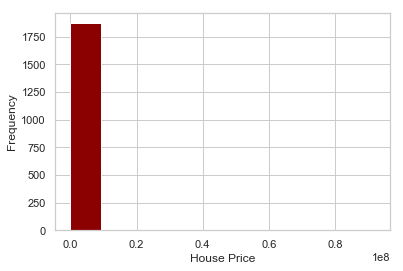

In [99]:
df1['total_price'].hist(color = "darkred")
plt.xlabel('House Price')
plt.ylabel('Frequency')

In [100]:
df1 = df1[df1['total_price'] >= 10000]
df1 = df1[np.abs(stats.zscore(df1['total_price'])) < 1]
df1 = df1[np.abs(stats.zscore(df1['price per sqft'])) < 1]
df1 = df1.drop(df1.index[(df1['building_type'] == "Apartment") & (df1['city'] == "SAN MATEO") & (df1['# of beds'] > 5.0)])
df1.drop(df1.index[(df1['# of beds'] > 10.0)], inplace=True)
df1 = df1.reset_index(drop=True)

In [101]:
# convert categorical to dummies
a = pd.get_dummies(df1[['building_type','city']], prefix=['Type', 'City'])

In [102]:
df1 = pd.concat([df1, a], axis=1)

In [103]:
df1.shape

(1795, 26)

In [104]:
# Outliers
df1 = df1.drop(df1.index[(df1['sqft'] >= 4000)])
df1 = df1.drop(df1.index[(df1['total_price'] >= 3000000)])
# df1 = df1.drop(df1.index[(df1['parking'] > 4)])     

### Exam the distribution of the target variable (house price) - log transformation applied

**Why distribution of dependent variable (house price) is so important?**

The dependent and independent variables in a regression model do not need to be normally distributed by themselves--only the prediction errors need to be normally distributed. But if the distributions of some of the variables that are random are extremely asymmetric or long-tailed, it may be hard to fit them into a linear model whose errors will be normally distributed.

In [105]:
# log transformation on house price
df1['total_price_log'] = np.log(df1['total_price'])

Text(0, 0.5, 'Frequency')

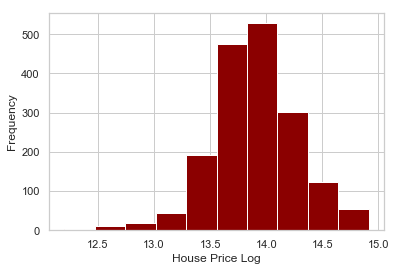

In [106]:
df1['total_price_log'].hist(color = "darkred")
plt.xlabel('House Price Log')
plt.ylabel('Frequency')

## Feature Engineering

Text(0, 0.5, 'House price')

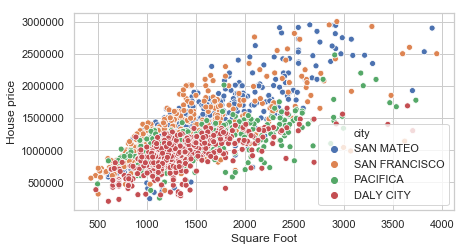

In [107]:
# relationship with numerical features
plt.figure(figsize=[15,8])
plt.subplot(2, 2, 3)
sns.scatterplot(data=df1, x="sqft", y="total_price", hue = "city", markers=["o", "s", "D", '+'])
plt.xlabel('Square Foot')
plt.ylabel('House price')

In [108]:
# count percentage of nan values
df1.dropna(subset=['sqft', 'price per sqft', '# of beds', '# of baths'], inplace = True)
total = df1.isnull().sum().sort_values(ascending=False)
percent = (df1.isnull().sum()/df1.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data

,Total,Percent
last_sold_on,26,0.014986
year_built,15,0.008646
total_price_log,0,0.000000
total_price,0,0.000000
building_type,0,0.000000
city,0,0.000000
parking,0,0.000000
postal_code,0,0.000000
state,0,0.000000
price per sqft,0,0.000000


In [109]:
uniqueVals = df1["# of beds"].unique()
uniqueVals

array([ 3.,  1.,  4.,  2.,  7.,  5.,  6.,  9., 10.])

In [110]:
df1 = df1[df1['building_type'].isin(['Apartment','Condo','Multi Family','Single Family'])]
df1 = df1.reset_index(drop=True)

**Pandas isna() vs isnull()**

These two DataFrame methods do exactly the same thing! Even their docs are identical. You can even confirm this in pandas' code.

But why have two methods with different names do the same thing?
This is because pandas' DataFrames are based on R's DataFrames. In R na and null are two separate things. 

However, in python, pandas is built on top of numpy, which has neither na nor null values. Instead numpy has NaN values (which stands for "Not a Number"). Consequently, pandas also uses NaN values.

In short
To detect NaN values numpy uses np.isnan().

To detect NaN values pandas uses either .isna() or .isnull().
The NaN values are inherited from the fact that pandas is built on top of numpy, while the two functions' names originate from R's DataFrames, whose structure and functionality pandas tried to mimic.

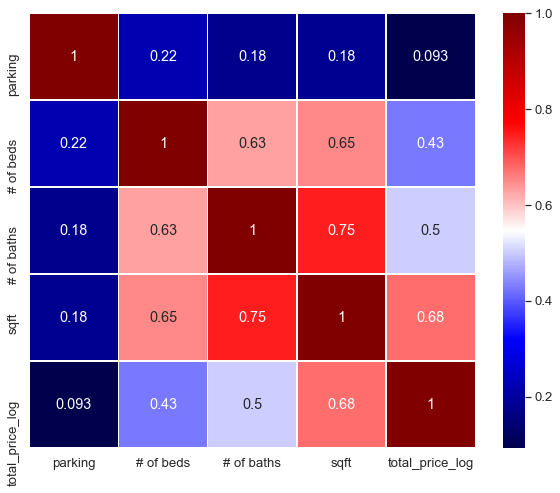

In [203]:
sns.set(font_scale=1.2)
plt.figure(figsize=[10,8])

df2 = df1[['parking', '# of beds','# of baths','sqft','total_price_log']]
sns.heatmap(df2.corr(), cmap="seismic", annot=True, linewidths=.5)

In [201]:
import pickle

with open('df1.pickle', 'wb') as to_write:
    pickle.dump(df1, to_write)